<a href="https://colab.research.google.com/github/gr3g-z/TCC-PUCSP-CDIA/blob/main/StoreSalesTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STORE SALES

## Extração dos Dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [3]:
df_test = pd.read_csv('/content/drive/MyDrive/store_sales/test.csv')
df_treino = pd.read_csv('/content/drive/MyDrive/store_sales/train.csv')
transactions = pd.read_csv('/content/drive/MyDrive/store_sales/transactions.csv')
feriados = pd.read_csv('/content/drive/MyDrive/store_sales/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/store_sales/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/store_sales/stores.csv')
sample = pd.read_csv('/content/drive/MyDrive/store_sales/sample_submission.csv')

In [4]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [5]:
df = pd.concat([df_treino, df_test], ignore_index=True)
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
stores = stores.drop(['cluster'], axis =1)
stores.head()

,store_nbr,city,state,type
0,1,Quito,Pichincha,D
1,2,Quito,Pichincha,D
2,3,Quito,Pichincha,D
3,4,Quito,Pichincha,D
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D


In [7]:
# Mesclar os dataframes usando a coluna "numero_loja" como chave
df = pd.merge(df, stores, on='store_nbr', how='left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D


## Análise Exploratória

In [8]:
print(f'shape do dataframe de teste: {df.shape}')
#Descarte do dataset de teste por faltar uma coluna importante

shape do dataframe de teste: (3029400, 9)


In [9]:
#Número de lojas
stores['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [10]:
#Número de Familias
len(df['family'].unique())

33

In [11]:
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   city         object 
 7   state        object 
 8   type         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 231.1+ MB


In [17]:
# Configuração para exibir números decimais sem notação científic
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Agrupando por store_nbr, family, city e state, somando as vendas
resultado = df.groupby(['store_nbr', 'family', 'city', 'state'])['sales'].sum().reset_index()

# Exibindo o resultado
resultado

,store_nbr,family,city,state,sales
0,1,AUTOMOTIVE,Quito,Pichincha,5475.000
1,1,BABY CARE,Quito,Pichincha,0.000
2,1,BEAUTY,Quito,Pichincha,4056.000
3,1,BEVERAGES,Quito,Pichincha,2673769.000
4,1,BOOKS,Quito,Pichincha,211.000
...,...,...,...,...,...
1777,54,POULTRY,El Carmen,Manabi,88889.812
1778,54,PREPARED FOODS,El Carmen,Manabi,103090.000
1779,54,PRODUCE,El Carmen,Manabi,596180.314
1780,54,SCHOOL AND OFFICE SUPPLIES,El Carmen,Manabi,1023.000


In [18]:
# COLUNAS COM M

# Criar coluna count_not_zero
resultado['count_not_zero'] = resultado['sales'].apply(lambda x: 1 if x != 0 else 0)

# Criar coluna sales_sum
resultado['sales_sum'] = resultado.groupby(['store_nbr', 'family'])['sales'].transform('sum')

# Criar coluna sales_mean
resultado['sales_mean'] = resultado.groupby(['store_nbr', 'family'])['sales'].transform('mean')

# Exibir o DataFrame resultante
resultado

,store_nbr,family,city,state,sales,count_not_zero,sales_sum,sales_mean
0,1,AUTOMOTIVE,Quito,Pichincha,5475.000,1,5475.000,5475.000
1,1,BABY CARE,Quito,Pichincha,0.000,0,0.000,0.000
2,1,BEAUTY,Quito,Pichincha,4056.000,1,4056.000,4056.000
3,1,BEVERAGES,Quito,Pichincha,2673769.000,1,2673769.000,2673769.000
4,1,BOOKS,Quito,Pichincha,211.000,1,211.000,211.000
...,...,...,...,...,...,...,...,...
1777,54,POULTRY,El Carmen,Manabi,88889.812,1,88889.812,88889.812
1778,54,PREPARED FOODS,El Carmen,Manabi,103090.000,1,103090.000,103090.000
1779,54,PRODUCE,El Carmen,Manabi,596180.314,1,596180.314,596180.314
1780,54,SCHOOL AND OFFICE SUPPLIES,El Carmen,Manabi,1023.000,1,1023.000,1023.000


## K means


In [19]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D


In [20]:
# Soma de vendas por loja
soma_vendas_por_loja = df.groupby('store_nbr')['sales'].sum().reset_index(name='soma_vendas')

# Ordenando de forma decrescente
soma_vendas_por_loja = soma_vendas_por_loja.sort_values(by='soma_vendas', ascending=False)

In [21]:
# Contagem de vendas por loja
contagem_vendas_por_loja = transactions.groupby('store_nbr')['transactions'].sum().reset_index(name='contagem_vendas')

# Ordenando de forma decrescente
contagem_vendas_por_loja = contagem_vendas_por_loja.sort_values(by='contagem_vendas', ascending=False)

In [25]:
df_kmeans = resultado
df_kmeans.head()

In [26]:
df_kmeans.head()

,store_nbr,family,city,state,sales,count_not_zero,sales_sum,sales_mean
0,1,AUTOMOTIVE,Quito,Pichincha,"5,475.00",1,"5,475.00","5,475.00"
1,1,BABY CARE,Quito,Pichincha,0.00,0,0.00,0.00
2,1,BEAUTY,Quito,Pichincha,"4,056.00",1,"4,056.00","4,056.00"
3,1,BEVERAGES,Quito,Pichincha,"2,673,769.00",1,"2,673,769.00","2,673,769.00"
4,1,BOOKS,Quito,Pichincha,211.00,1,211.00,211.00


In [27]:
df_kmeans = df_kmeans.drop(['city','state','sales'], axis =1)

In [28]:
lista_dias_com_dados = []
for i in range(1,55):
  resultado_1 = df_kmeans

  # Acessar a coluna 'count_not_zero' da primeira instância e salvar os valores em uma lista
  primeira_instancia_count_not_zero = resultado_1.loc[0, 'count_not_zero']
  lista_dias_com_dados.append(primeira_instancia_count_not_zero)

In [29]:
data = {'loja': soma_vendas_por_loja['store_nbr'],
        'Soma vendas totais': soma_vendas_por_loja['soma_vendas'],
        'Contagem vendas totais': contagem_vendas_por_loja['contagem_vendas'],
        'Média por venda': soma_vendas_por_loja['soma_vendas']/contagem_vendas_por_loja['contagem_vendas'],
        'Dias com dados': lista_dias_com_dados}

In [30]:
df_tamanho = pd.DataFrame(data)
df_tamanho['Média do faturamento por dia'] = df_tamanho['Soma vendas totais']/df_tamanho['Dias com dados']
df_tamanho['Média de vendas por dia'] = df_tamanho['Contagem vendas totais']/df_tamanho['Dias com dados']
df_tamanho

,loja,Soma vendas totais,Contagem vendas totais,Média por venda,Dias com dados,Média do faturamento por dia,Média de vendas por dia
0,1,"14,145,012.87",2553963,5.54,1,"14,145,012.87","2,553,963.00"
1,2,"21,557,388.64",3219901,6.70,1,"21,557,388.64","3,219,901.00"
2,3,"50,481,910.19",5366350,9.41,1,"50,481,910.19","5,366,350.00"
3,4,"18,909,700.38",2519007,7.51,1,"18,909,700.38","2,519,007.00"
4,5,"15,592,404.57",2347877,6.64,1,"15,592,404.57","2,347,877.00"
5,6,"25,183,680.00",3065896,8.21,1,"25,183,680.00","3,065,896.00"
6,7,"26,952,049.58",2995993,9.00,1,"26,952,049.58","2,995,993.00"
7,8,"30,494,286.93",4637971,6.57,1,"30,494,286.93","4,637,971.00"
8,9,"26,409,441.06",3516162,7.51,1,"26,409,441.06","3,516,162.00"
9,10,"9,613,905.74",1652493,5.82,1,"9,613,905.74","1,652,493.00"


In [31]:
#excluindo os atributos que não serão trabalhados pelo algorítmo
df_pre = df_tamanho.drop(['loja', 'Média por venda','Dias com dados','Contagem vendas totais','Soma vendas totais'], axis=1)

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_pre)

In [33]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_scaled)

labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
labels

array([1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 0, 0, 1, 1, 1], dtype=int32)

In [35]:
df_clusterizado = pd.concat([df_tamanho, pd.DataFrame({'cluster' : labels})], axis=1)
df_clusterizado

,loja,Soma vendas totais,Contagem vendas totais,Média por venda,Dias com dados,Média do faturamento por dia,Média de vendas por dia,cluster
0,1,"14,145,012.87",2553963,5.54,1,"14,145,012.87","2,553,963.00",1
1,2,"21,557,388.64",3219901,6.70,1,"21,557,388.64","3,219,901.00",0
2,3,"50,481,910.19",5366350,9.41,1,"50,481,910.19","5,366,350.00",2
3,4,"18,909,700.38",2519007,7.51,1,"18,909,700.38","2,519,007.00",0
4,5,"15,592,404.57",2347877,6.64,1,"15,592,404.57","2,347,877.00",1
5,6,"25,183,680.00",3065896,8.21,1,"25,183,680.00","3,065,896.00",0
6,7,"26,952,049.58",2995993,9.00,1,"26,952,049.58","2,995,993.00",0
7,8,"30,494,286.93",4637971,6.57,1,"30,494,286.93","4,637,971.00",0
8,9,"26,409,441.06",3516162,7.51,1,"26,409,441.06","3,516,162.00",0
9,10,"9,613,905.74",1652493,5.82,1,"9,613,905.74","1,652,493.00",1


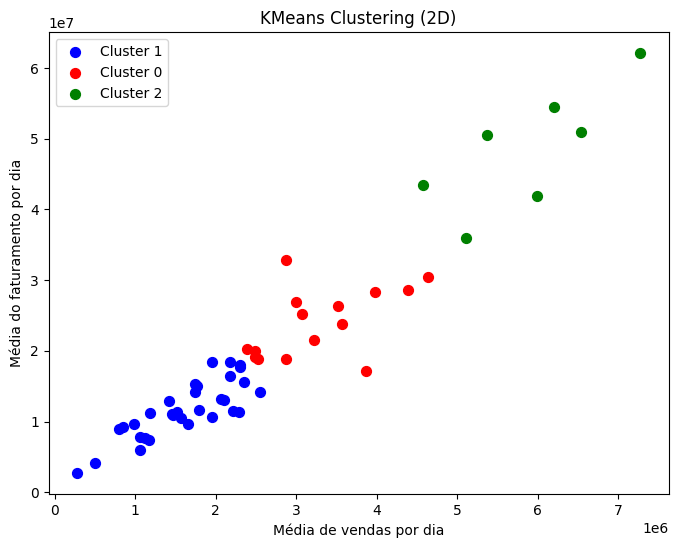

In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supondo que você já tenha treinado o modelo KMeans e adicionado os rótulos ao DataFrame
# Substitua 'labels' pelo nome da coluna que contém os rótulos de cluster em seu DataFrame.

plt.figure(figsize=(8, 6))

# Mapear cores para clusters
colors = ['red', 'blue', 'green', 'purple', 'orange']

for cluster in df_clusterizado['cluster'].unique():
    cluster_data = df_clusterizado[df_clusterizado['cluster'] == cluster]
    plt.scatter(cluster_data['Média de vendas por dia'], cluster_data['Média do faturamento por dia'],
                label=f'Cluster {cluster}', c=colors[cluster], s=50)  # 'c' define a cor, 's' define o tamanho dos pontos

# Adicionar legendas e título
plt.xlabel('Média de vendas por dia')
plt.ylabel('Média do faturamento por dia')
plt.title('KMeans Clustering (2D)')

# Adicionar legenda
plt.legend()
plt.show()


### Conclusão
* 0 = empresas de médio porte
* 1 = empresas de pequeno porte
* 2 = empresas de grande porte

## Séries Temporais - Facebook Prophet

<ipython-input-37-6808667c870c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novo['date'] = pd.to_datetime(df_novo['date'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgjyonbo/7d3kp13l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgjyonbo/4qjb9c2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6744', 'data', 'file=/tmp/tmpdgjyonbo/7d3kp13l.json', 'init=/tmp/tmpdgjyonbo/4qjb9c2_.json', 'output', 'file=/tmp/tmpdgjyonbo/prophet_modelxqyvc29l/prophet_model-20231128172745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

             ds     yhat  yhat_lower  yhat_upper
0    2013-01-02 3,586.89    3,284.31    3,872.94
1    2013-01-03 3,244.28    2,937.83    3,559.56
2    2013-01-04 3,516.79    3,205.66    3,804.58
3    2013-01-05 3,859.22    3,571.05    4,156.53
4    2013-01-06 3,674.37    3,360.83    3,953.14
...         ...      ...         ...         ...
1851 2018-02-07 3,180.23    2,880.29    3,489.04
1852 2018-02-08 2,907.42    2,596.50    3,207.05
1853 2018-02-09 3,247.94    2,945.89    3,522.84
1854 2018-02-10 3,655.85    3,355.72    3,962.24
1855 2018-02-11 3,533.23    3,207.92    3,843.05

[1856 rows x 4 columns]


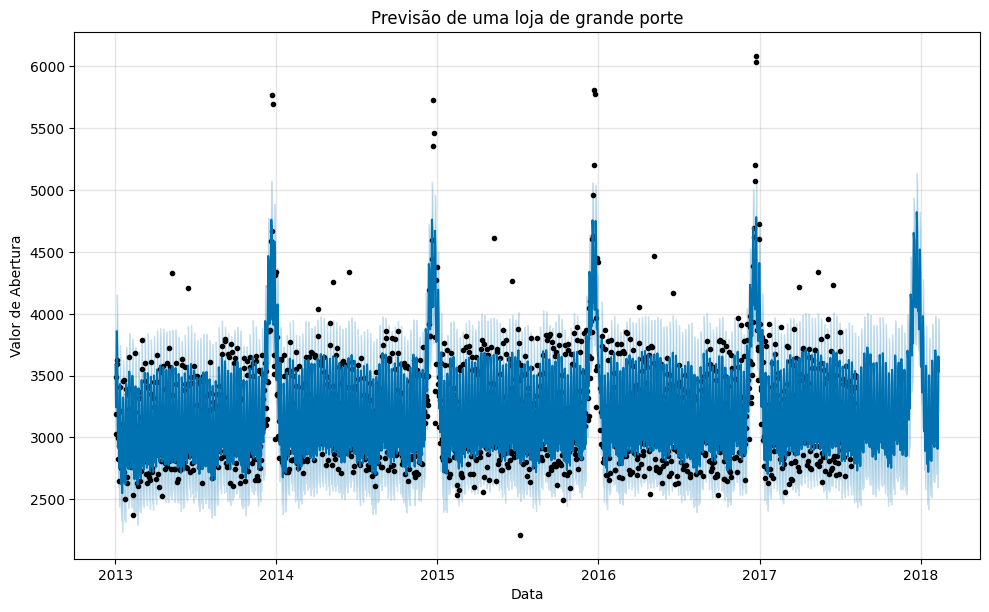

In [37]:
# Criar um novo DataFrame filtrando os valores da coluna "sorte_nbr"
df_novo = transactions[transactions['store_nbr'] ==3]
df_novo['date'] = pd.to_datetime(df_novo['date'])
df_novo
# Substitua 'nome_da_coluna' pelo nome real da coluna que você deseja dropar
nome_da_coluna = 'store_nbr'

# Use o método drop para remover a coluna
df_st = df_novo.drop(nome_da_coluna, axis=1)
df_st = df_st.rename(columns={'date': 'ds', 'transactions': 'y'})
df_st

# Crie e ajuste o modelo Prophet
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(df_st)

# Crie um DataFrame para as datas futuras que você deseja prever
future = model.make_future_dataframe(periods=180)  # 60 dias no futuro

# Faça as previsões para as datas futuras
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Visualize as previsões
fig = model.plot(forecast)
plt.title('Previsão de uma loja de grande porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()

<ipython-input-38-28dc323ad637>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_novo['date'] = pd.to_datetime(df_novo['date'])
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgjyonbo/ejl62nnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdgjyonbo/58ao5aoj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35489', 'data', 'file=/tmp/tmpdgjyonbo/ejl62nnw.json', 'init=/tmp/tmpdgjyonbo/58ao5aoj.json', 'output', 'file=/tmp/tmpdgjyonbo/prophet_model248q2zce/prophet_model-20231128172752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

             ds     yhat  yhat_lower  yhat_upper
0    2013-01-02 2,207.04    1,993.24    2,422.64
1    2013-01-03 2,025.24    1,826.40    2,251.15
2    2013-01-04 2,106.26    1,880.29    2,310.12
3    2013-01-05 2,205.96    1,991.14    2,423.68
4    2013-01-06 2,062.67    1,845.29    2,292.65
...         ...      ...         ...         ...
1852 2018-02-07 1,922.01    1,704.29    2,140.45
1853 2018-02-08 1,773.12    1,560.05    1,980.42
1854 2018-02-09 1,886.14    1,662.76    2,105.10
1855 2018-02-10 2,016.60    1,806.42    2,227.07
1856 2018-02-11 1,902.50    1,683.52    2,114.77

[1857 rows x 4 columns]


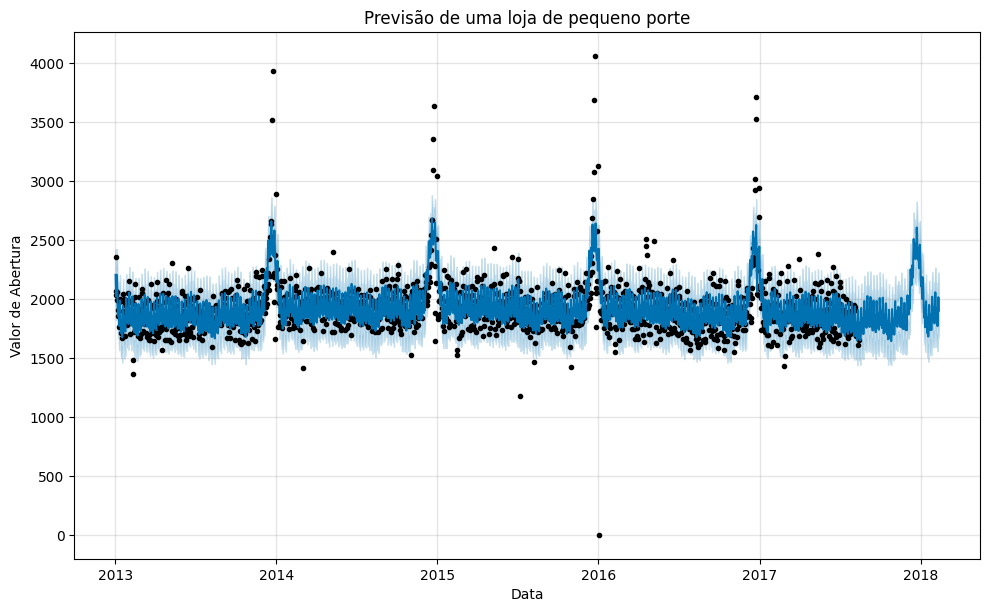

In [38]:
# Criar um novo DataFrame filtrando os valores da coluna "sorte_nbr"
df_novo = transactions[transactions['store_nbr'] ==2]
df_novo['date'] = pd.to_datetime(df_novo['date'])
df_novo
# Substitua 'nome_da_coluna' pelo nome real da coluna que você deseja dropar
nome_da_coluna = 'store_nbr'

# Use o método drop para remover a coluna
df_st = df_novo.drop(nome_da_coluna, axis=1)
df_st = df_st.rename(columns={'date': 'ds', 'transactions': 'y'})
df_st

# Crie e ajuste o modelo Prophet
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(df_st)

# Crie um DataFrame para as datas futuras que você deseja prever
future = model.make_future_dataframe(periods=180)  # 60 dias no futuro

# Faça as previsões para as datas futuras
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Visualize as previsões
fig = model.plot(forecast)
plt.title('Previsão de uma loja de pequeno porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()